# Two time correlation example notebook

In [1]:
import skbeam.core.correlation as corr
from skbeam.core.correlation import two_time_corr, two_time_state_to_results
import skbeam.core.roi as roi
import skbeam.core.utils as utils

from xray_vision.mpl_plotting.roi import show_label_array_on_image

import numpy as np
import time as ttime
import matplotlib.pyplot as plt
%matplotlib notebook

## Using synthetic data

In [3]:
num_levels = 5
num_bufs = 4  # must be even
xdim = 512
ydim = 512
stack_size = 100
synthetic_data = np.random.randint(1, 10, (stack_size, xdim, ydim))

rois = np.zeros_like(synthetic_data[0])
# make sure that the ROIs can be any integers greater than 1. They do not
# have to start at 1 and be continuous
rois[0:xdim//10, 0:ydim//10] = 5
rois[xdim//10:xdim//5, ydim//10:ydim//5] = 3

<IPython.core.display.Javascript object>


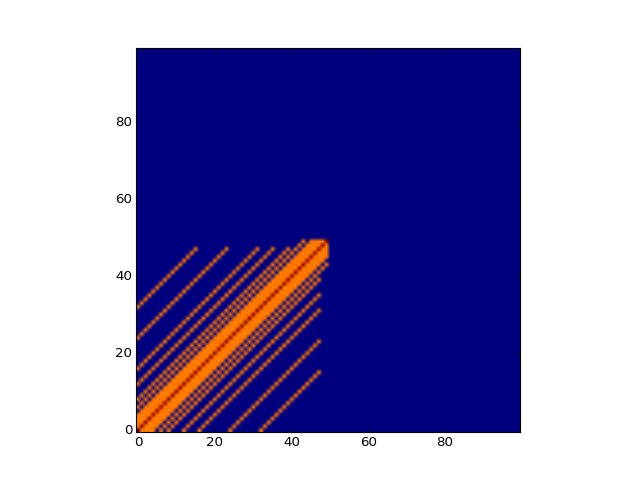

In [5]:
two_time = corr.two_time_corr(rois, synthetic_data[:50], stack_size, num_bufs, num_levels)
fig, ax = plt.subplots()
plt.imshow(two_time[0][:, :, 0], origin="lower")
plt.show()

## With real data

In [6]:
# multi-tau scheme info
real_data_levels = 7
real_data_bufs = 8
real_data = np.load("100_500_NIPA_GEL.npy")

avg_img = np.average(real_data, axis=0)

# generate some circular ROIs
# define the ROIs
roi_start = 65 # in pixels
roi_width = 9 # in pixels
roi_spacing = (5.0, 4.0)
x_center = 7. # in pixels
y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, (y_center, x_center), real_data.shape[1:])

<IPython.core.display.Javascript object>


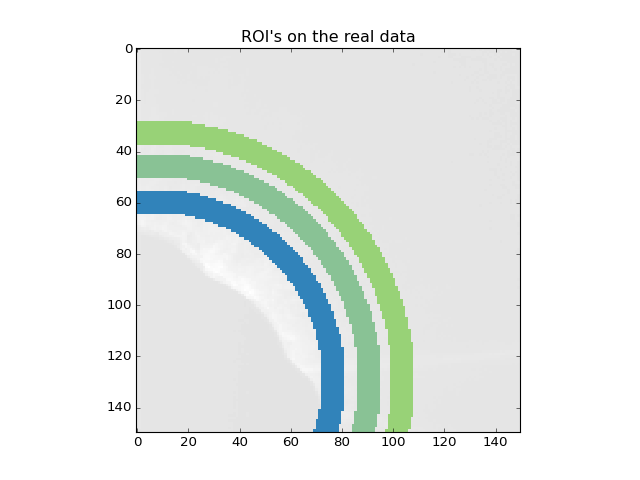

In [7]:
fig, ax = plt.subplots()
ax.imshow(np.sum(real_data, axis=0) / len(real_data))
show_label_array_on_image(ax, avg_img, labeled_roi_array)
plt.title("ROI's on the real data")
plt.show()

<IPython.core.display.Javascript object>


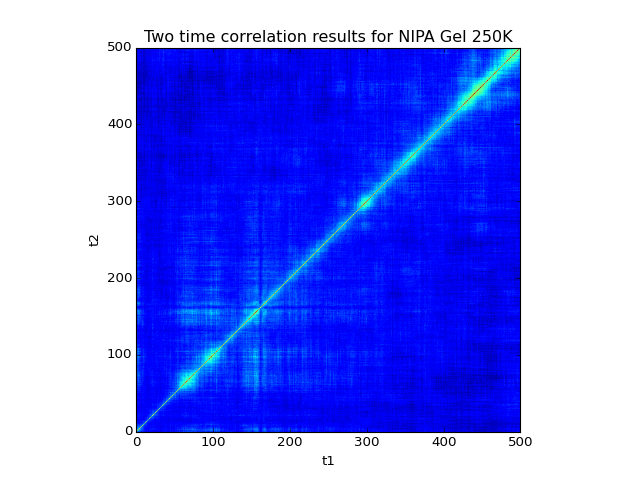

In [8]:
two_time = corr.two_time_corr(labeled_roi_array, real_data, real_data.shape[0], real_data.shape[0], num_levels=1)
fig, ax = plt.subplots()
plt.imshow(two_time[0][:, :, 0], origin="lower")
plt.xlabel("t1")
plt.ylabel("t2")
plt.title("Two time correlation results for NIPA Gel 250K")
plt.show()

In [9]:
# run the correlation on the full stack
full_gen = corr.lazy_two_time(labeled_roi_array, real_data, real_data.shape[0],
                             real_data.shape[0], 1)
for full_state in full_gen:
        pass

In [10]:
final_result = corr.two_time_state_to_results(full_state)

In [12]:
# run the correlation on the first half
gen_first_half = corr.lazy_two_time(labeled_roi_array, real_data[:real_data.shape[0]//2], real_data.shape[0],
                                   num_bufs=real_data.shape[0], num_levels=1)
for first_half_state in gen_first_half:
        pass
# run the correlation on the second half by passing in the state from the
# first half
gen_second_half = corr.lazy_two_time(labeled_roi_array, real_data[real_data.shape[0]//2:],
                                    real_data.shape[0], num_bufs=real_data.shape[0],                                     num_levels=1,
                                     two_time_internal_state=first_half_state)

for second_half_state in gen_second_half:
       pass
result = corr.two_time_state_to_results(second_half_state)   

<IPython.core.display.Javascript object>


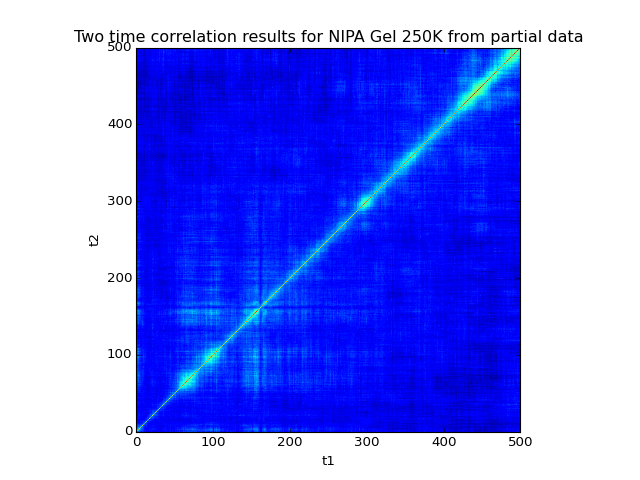

In [13]:
fig, ax = plt.subplots()
plt.imshow(result.g2[:, :, 0], origin="lower")
plt.xlabel("t1")
plt.ylabel("t2")
plt.title("Two time correlation results for NIPA Gel 250K from partial data")
plt.show()

In [14]:
np.all(result.g2 == two_time[0])

True